/tmp/ipython-input-3900452205.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


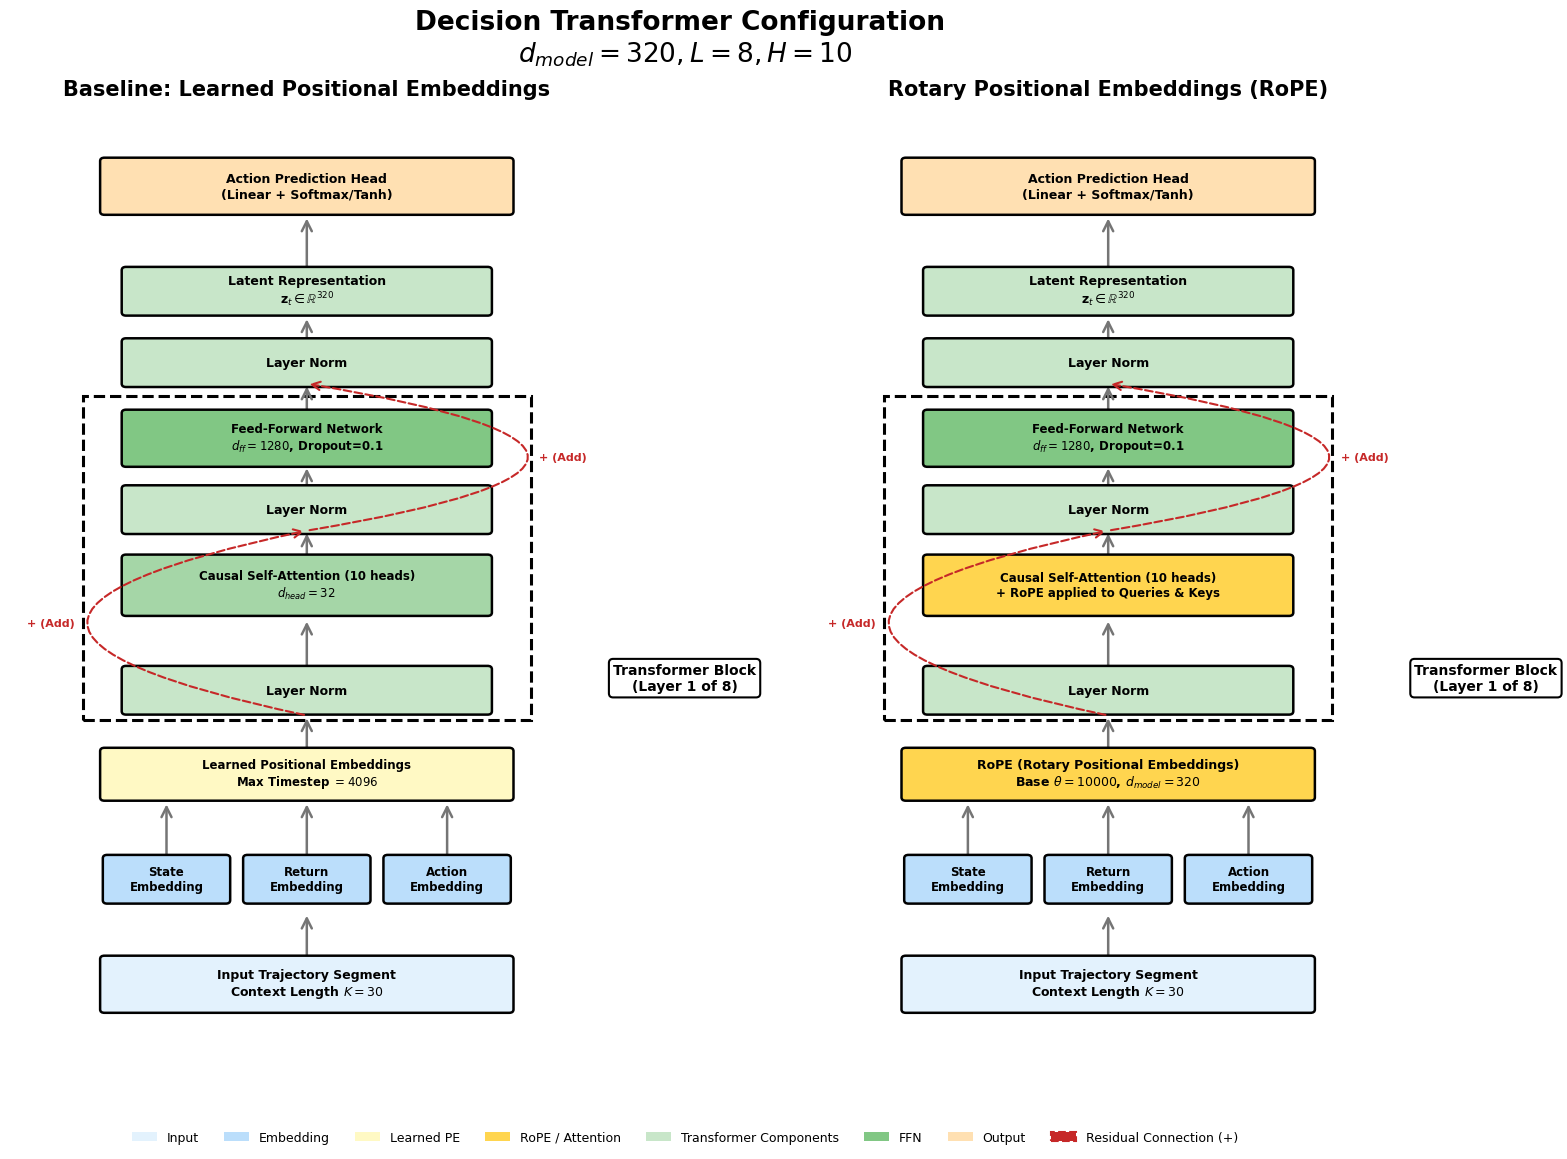

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle
import numpy as np

def create_decision_transformer_architecture_with_residuals():
    """
    Creates a visualization of the Decision Transformer architecture
    consistent with Config v2.1.0 parameters, including residual connections.
    """
    fig = plt.figure(figsize=(18, 12))

    # Create two subplots side by side
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.35)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # Color scheme
    colors = {
        'input': '#E3F2FD',
        'embedding': '#BBDEFB',
        'positional': '#FFF9C4',
        'transformer': '#C8E6C9',
        'attention': '#A5D6A7',
        'ffn': '#81C784',
        'output': '#FFE0B2',
        'rope': '#FFD54F',
        'arrow': '#757575',
        'residual': '#C62828' # Distinct red for residuals
    }

    def draw_architecture(ax, title, use_rope=False):
        ax.set_xlim(0, 11)
        ax.set_ylim(0, 22)
        ax.axis('off')
        ax.set_title(title, fontsize=15, fontweight='bold', pad=20)

        # Layer positions
        y_positions = {
            'input': 1.5,
            'embed': 4.0,
            'pos_enc': 6.5,
            'transformer_in': 8.5,
            'attention': 11.0,
            'norm1': 12.8,
            'ffn': 14.5,
            'norm2': 16.3,
            'transformer_out': 18.0,
            'output': 20.5
        }

        box_width = 7.5
        box_height = 1.0
        x_center = 5.5
        inner_box_width = box_width - 0.8

        def draw_box(y, label, color, height=box_height, width=box_width, fontsize=9):
            box = FancyBboxPatch(
                (x_center - width/2, y - height/2),
                width, height,
                boxstyle="round,pad=0.08",
                facecolor=color,
                edgecolor='black',
                linewidth=1.8,
                zorder=10
            )
            ax.add_patch(box)
            ax.text(x_center, y, label, ha='center', va='center',
                   fontsize=fontsize, fontweight='bold', zorder=11)

        def draw_arrow(y_start, y_end, x=x_center, style='->'):
            arrow = FancyArrowPatch(
                (x, y_start), (x, y_end),
                arrowstyle=style,
                color=colors['arrow'],
                linewidth=1.8,
                mutation_scale=18,
                zorder=5
            )
            ax.add_patch(arrow)

        # Helper for residual arrows
        def draw_residual(y_start, y_end, x_offset, rad):
            # Points just before and after the blocks being skipped
            start_pt = (x_center, y_start)
            end_pt = (x_center, y_end)

            arrow = FancyArrowPatch(
                start_pt, end_pt,
                connectionstyle=f"arc3,rad={rad}", # Curved arrow
                arrowstyle='->',
                color=colors['residual'],
                linewidth=1.5,
                linestyle='--',
                mutation_scale=15,
                zorder=15 # Ensure it's on top
            )
            ax.add_patch(arrow)

            # Add a little "+" sign at the rejoin point
            mid_y = (y_start + y_end) / 2
            # Adjust label position based on side
            label_x = x_center + x_offset * 1.25
            ax.text(label_x, mid_y, '+ (Add)', color=colors['residual'],
                   ha='center', va='center', fontsize=8, fontweight='bold', zorder=16)

        # 1. Input Layer
        draw_box(y_positions['input'],
                'Input Trajectory Segment\nContext Length $K=30$',
                colors['input'], height=1.2, fontsize=9)

        draw_arrow(y_positions['input'] + 0.6, y_positions['embed'] - 0.8)

        # 2. Embedding Layer
        embed_y = y_positions['embed']
        embed_width = 2.2
        embed_spacing = 2.6

        # State embedding
        ax.add_patch(FancyBboxPatch((x_center - embed_spacing - embed_width/2, embed_y - box_height/2),
            embed_width, box_height, boxstyle="round,pad=0.08", facecolor=colors['embedding'], edgecolor='black', linewidth=1.8, zorder=10))
        ax.text(x_center - embed_spacing, embed_y, 'State\nEmbedding', ha='center', va='center', fontsize=8.5, fontweight='bold', zorder=11)

        # Return embedding
        ax.add_patch(FancyBboxPatch((x_center - embed_width/2, embed_y - box_height/2),
            embed_width, box_height, boxstyle="round,pad=0.08", facecolor=colors['embedding'], edgecolor='black', linewidth=1.8, zorder=10))
        ax.text(x_center, embed_y, 'Return\nEmbedding', ha='center', va='center', fontsize=8.5, fontweight='bold', zorder=11)

        # Action embedding
        ax.add_patch(FancyBboxPatch((x_center + embed_spacing - embed_width/2, embed_y - box_height/2),
            embed_width, box_height, boxstyle="round,pad=0.08", facecolor=colors['embedding'], edgecolor='black', linewidth=1.8, zorder=10))
        ax.text(x_center + embed_spacing, embed_y, 'Action\nEmbedding', ha='center', va='center', fontsize=8.5, fontweight='bold', zorder=11)

        draw_arrow(embed_y + 0.5, y_positions['pos_enc'] - 0.65, x=x_center - embed_spacing)
        draw_arrow(embed_y + 0.5, y_positions['pos_enc'] - 0.65)
        draw_arrow(embed_y + 0.5, y_positions['pos_enc'] - 0.65, x=x_center + embed_spacing)

        # 3. Positional Encoding
        if use_rope:
            draw_box(y_positions['pos_enc'],
                    'RoPE (Rotary Positional Embeddings)\nBase $\\theta=10000$, $d_{model}=320$',
                    colors['rope'], height=1.1, fontsize=9)
        else:
            draw_box(y_positions['pos_enc'],
                    'Learned Positional Embeddings\nMax Timestep $= 4096$',
                    colors['positional'], height=1.1, fontsize=8.5)

        # Y-coordinate just before entering the transformer block
        y_pre_block = y_positions['transformer_in'] - 0.6
        draw_arrow(y_positions['pos_enc'] + 0.55, y_pre_block)

        # 4. Transformer Block
        transformer_height = 10.0
        transformer_box = Rectangle(
            (x_center - box_width/2 - 0.4, y_positions['transformer_in'] - 0.7),
            box_width + 0.8, transformer_height-2.3,
            facecolor='white', edgecolor='black', linewidth=2.2, linestyle='--', zorder=1
        )
        ax.add_patch(transformer_box)
        ax.text(x_center + 7, y_positions['transformer_in'],
               'Transformer Block\n(Layer 1 of 8)',
               ha='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=1.5))

        # --- Residual 1 Start Point (Before Attn Block) ---
        y_res1_start = y_pre_block

        draw_box(y_positions['transformer_in'], 'Layer Norm', colors['transformer'], width=inner_box_width)
        draw_arrow(y_positions['transformer_in'] + 0.5, y_positions['attention'] - 0.8)

        # Multi-Head Attention
        if use_rope:
            draw_box(y_positions['attention'],
                    'Causal Self-Attention (10 heads)\n+ RoPE applied to Queries & Keys',
                    colors['rope'], height=1.3, width=inner_box_width, fontsize=8.5)
        else:
            draw_box(y_positions['attention'],
                    'Causal Self-Attention (10 heads)\n$d_{head}=32$',
                    colors['attention'], height=1.3, width=inner_box_width, fontsize=8.5)

        # Y-coordinate between Attn block and FFN block
        y_inter_block = y_positions['norm1'] - 0.5
        draw_arrow(y_positions['attention'] + 0.65, y_inter_block)

        # --- Residual 1 End / Residual 2 Start ---
        # Draw Residual 1 (Left side, curving out)
        draw_residual(y_res1_start, y_inter_block, x_offset=-3.8, rad=-2.37)
        y_res2_start = y_inter_block

        draw_box(y_positions['norm1'], 'Layer Norm', colors['transformer'], width=inner_box_width)
        draw_arrow(y_positions['norm1'] + 0.5, y_positions['ffn'] - 0.65)

        # Feed-Forward Network
        draw_box(y_positions['ffn'],
                'Feed-Forward Network\n$d_{ff}=1280$, Dropout=0.1',
                colors['ffn'], height=1.2, width=inner_box_width, fontsize=8.5)

        # Y-coordinate after FFN block, before final LN
        y_post_ffn = y_positions['norm2'] - 0.5
        draw_arrow(y_positions['ffn'] + 0.6, y_post_ffn)

        # --- Residual 2 End ---
        # Draw Residual 2 (Right side, curving out)
        draw_residual(y_res2_start, y_post_ffn, x_offset=3.8, rad=3.0)

        # Final Layer Norm (Wait, standard pre-norm usually ends here.
        # The original diagram had 3 LNs. Keeping consistency with original diagram structure
        # where norm2 is the final LN of the block before output)
        draw_box(y_positions['norm2'], 'Layer Norm', colors['transformer'], width=inner_box_width)
        draw_arrow(y_positions['norm2'] + 0.5, y_positions['transformer_out'] - 0.6)

        # Transformer output
        draw_box(y_positions['transformer_out'],
                'Latent Representation\n$\\mathbf{z}_t \\in \\mathbb{R}^{320}$',
                colors['transformer'], height=1.0, width=inner_box_width, fontsize=9)

        draw_arrow(y_positions['transformer_out'] + 0.5, y_positions['output'] - 0.7)

        # 5. Output Layer
        draw_box(y_positions['output'],
                'Action Prediction Head\n(Linear + Softmax/Tanh)',
                colors['output'], height=1.2, fontsize=9)

    # Draw both architectures
    draw_architecture(ax1, 'Baseline: Learned Positional Embeddings', use_rope=False)
    draw_architecture(ax2, 'Rotary Positional Embeddings (RoPE)', use_rope=True)

    fig.suptitle('Decision Transformer Configuration \n$d_{model}=320, L=8, H=10$',
                fontsize=19, fontweight='bold', y=0.975)

    # Add legend including residual
    legend_elements = [
        mpatches.Patch(facecolor=colors['input'], label='Input'),
        mpatches.Patch(facecolor=colors['embedding'], label='Embedding'),
        mpatches.Patch(facecolor=colors['positional'], label='Learned PE'),
        mpatches.Patch(facecolor=colors['rope'], label='RoPE / Attention'),
        mpatches.Patch(facecolor=colors['transformer'], label='Transformer Components'),
        mpatches.Patch(facecolor=colors['ffn'], label='FFN'),
        mpatches.Patch(facecolor=colors['output'], label='Output'),
        FancyArrowPatch((0,0),(1,1), arrowstyle='->', color=colors['residual'], linestyle='--', label='Residual Connection (+)', linewidth=1.5)
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=8,
              fontsize=9, frameon=False, bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

fig = create_decision_transformer_architecture_with_residuals()
plt.show()

Figure saved to key_door_env.pdf


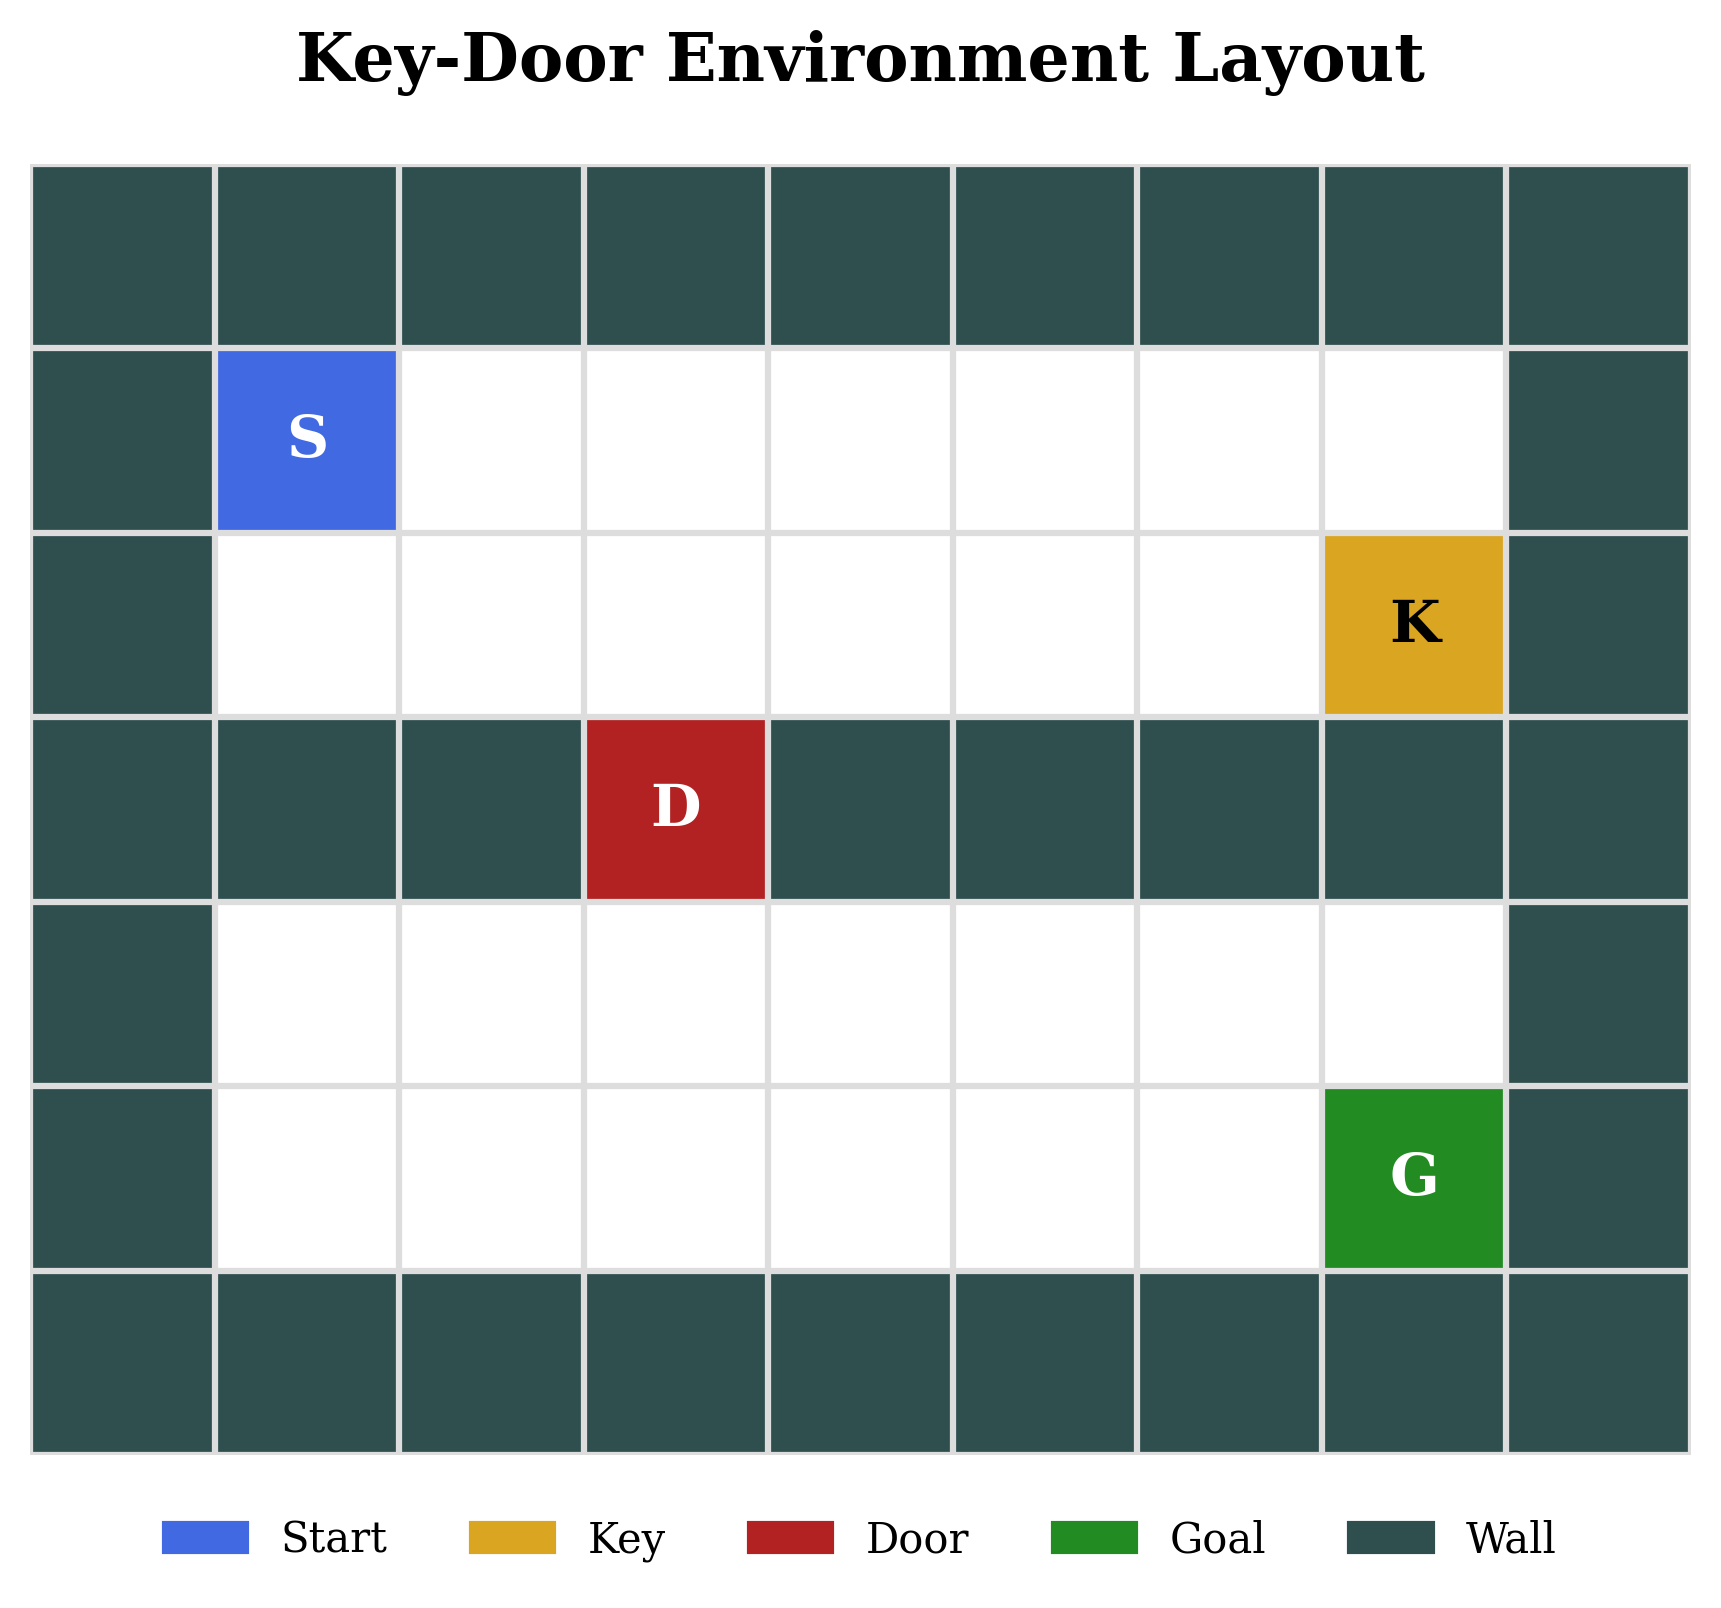

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# Set global font to a serif font (common in academic publications like IEEE/ACM)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 12
})

def plot_publication_grid(grid_layout,
                          title="Key-Door Environment",
                          overlay_text=True,
                          save_path=None):
    """
    Generates a high-quality visualization of a grid world.

    Args:
        grid_layout (list of str): The map layout.
        title (str): Title of the figure.
        overlay_text (bool): If True, overlays characters (K, D, etc.) on cells
                             for black-and-white readability.
        save_path (str, optional): If provided, saves the figure to this path
                                   (e.g., 'figure.pdf').
    """

    # --- 1. Setup Data and Colors ---
    # Mapping chars to integers
    element_map = {'.': 0, '#': 1, 'S': 2, 'K': 3, 'D': 4, 'G': 5}

    # Professional Color Palette (Colorblind friendly & high contrast)
    # 0: Floor (White)
    # 1: Wall (Dark Slate Gray - softer than pure black)
    # 2: Start (Royal Blue)
    # 3: Key (Goldenrod)
    # 4: Door (Firebrick Red)
    # 5: Goal (Forest Green)
    colors = ['#ffffff', '#2f4f4f', '#4169e1', '#daa520', '#b22222', '#228b22']
    cmap = mcolors.ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Convert text layout to numeric matrix
    rows = len(grid_layout)
    cols = len(grid_layout[0])
    grid_data = np.zeros((rows, cols))

    for r in range(rows):
        for c in range(cols):
            char = grid_layout[r][c]
            grid_data[r, c] = element_map.get(char, 0)

    # --- 2. Create Plot ---
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300) # High DPI for preview

    # Render the grid
    ax.imshow(grid_data, cmap=cmap, norm=norm)

    # --- 3. Aesthetic Refinements ---
    # Add subtle grid lines to separate cells
    ax.set_xticks(np.arange(-0.5, cols, 1))
    ax.set_yticks(np.arange(-0.5, rows, 1))
    ax.grid(which='major', color='#dddddd', linestyle='-', linewidth=1.5)

    # Remove axis ticks and labels for a clean look
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove the surrounding spine/border for a cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)

    # --- 4. Text Overlay (Crucial for B&W Printing) ---
    if overlay_text:
        for r in range(rows):
            for c in range(cols):
                char = grid_layout[r][c]
                if char != '.' and char != '#':
                    # Determine text color based on background brightness
                    # White text for dark backgrounds (Door, Goal, Start)
                    # Black text for light backgrounds (Key)
                    text_color = 'white' if char in ['D', 'G', 'S'] else 'black'

                    ax.text(c, r, char,
                            ha='center', va='center',
                            color=text_color,
                            fontweight='bold', fontsize=14)

    # --- 5. Legend ---
    # Create legend handles manually for perfect control
    labels = {
        'Start': colors[2],
        'Key': colors[3],
        'Door': colors[4],
        'Goal': colors[5],
        'Wall': colors[1]
    }
    patches = [mpatches.Patch(color=color, label=label) for label, color in labels.items()]

    # Place legend below the plot (common in papers to save side-width)
    ax.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.02),
              fancybox=False, shadow=False, ncol=5, frameon=False, fontsize=10)

    plt.title(title, pad=20, fontsize=16, fontweight='bold')
    plt.tight_layout()

    # --- 6. Save or Show ---
    if save_path:
        # savefig with bbox_inches='tight' prevents cutting off the legend
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# --- Example Configuration ---
level_layout = [
    "#########",
    "#S......#",
    "###.#####",
    "#K#.#G..#",
    "#...D...#",
    "#...#####",
    "#########"
]

level_layout2 = [
    "#########",
    "#S......#",
    "#......K#",
    "###D#####",
    "#.......#",
    "#......G#",
    "#########"
]


if __name__ == "__main__":
    # Save as PDF for LaTeX integration
    plot_publication_grid(level_layout2,
                          title="Key-Door Environment Layout",
                          save_path="key_door_env.pdf")